In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default() 
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [2]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import os
os.chdir('drive/brat')

In [7]:
!ls

Brain Tumor Segmentation.odt  slice_126_0
data.ipynb		      slice_126_1
data_trial_81.h5	      slice_126_2
data_trial_dim2_128.h5	      slice_126_3
data_Y_0001.pickle	      slice_126_GT
FinalCode.ipynb		      training.ipynb
HG			      trial_0001_2path_acc.h5
info1_input.h5		      trial_0001_accuracy.h5
info_mfc.h5		      trial_0001_input_cascasde_acc.h5
LG			      trial_0001_MFCcas_dim2_128_acc.h5
MFC_cascade_siam.h5	      trial_MFCcascade_acc.h5
model.ipynb		      untitled.ipynb
siamese_training.ipynb


In [2]:
!pip3 install SimpleITK

In [0]:
import SimpleITK as sitk
import numpy as np

Data Visualisations

In [7]:
import os
path = 'HG/0001'
p = os.listdir(path)
p.sort(key=str.lower)
arr = []
for i in range(len(p)):
  if(i != 4):
    p1 = os.listdir(path+'/'+p[i])
    p1.sort()
    img = sitk.ReadImage(path+'/'+p[i]+'/'+p1[-1])
    arr.append(sitk.GetArrayFromImage(img))
  else:
    p1 = os.listdir(path+'/'+p[i])
    img = sitk.ReadImage(path+'/'+p[i]+'/'+p1[0])
    Y_labels = sitk.GetArrayFromImage(img) 
    print(Y_labels.shape)
data = np.zeros((Y_labels.shape[1],Y_labels.shape[0],Y_labels.shape[2],4))
for i in range(Y_labels.shape[1]):
  data[i,:,:,0] = arr[0][:,i,:]
  data[i,:,:,1] = arr[1][:,i,:]
  data[i,:,:,2] = arr[2][:,i,:]
  data[i,:,:,3] = arr[3][:,i,:]

(176, 216, 160)


Populating the interactive namespace from numpy and matplotlib


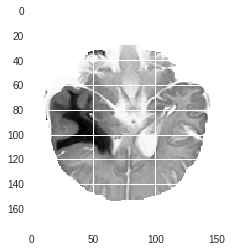

In [14]:
%pylab inline
import matplotlib.pyplot as plt
img = data[126,:,:,0]
imgplot = plt.imshow(img)
plt.show()
plt.imsave('slice_126_4',img,cmap='gray')

Populating the interactive namespace from numpy and matplotlib


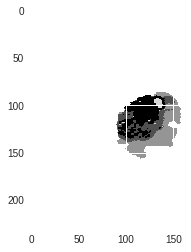

In [28]:
%pylab inline
import matplotlib.pyplot as plt
img = Y_labels[:,126,:]
imgplot = plt.imshow(img)
plt.show()
#plt.imsave('slice_126_GT',img,cmap='gray')

In [0]:
def model_gen(input_dim,x,y,slice_no):
  X1 = []
  X2 = []
  Y = []
  
  for i in range(int((input_dim)/2),y.shape[0]-int((input_dim)/2)):
    for j in range(int((input_dim)/2),y.shape[2]-int((input_dim)/2)):
      #Filtering all 0 patches
      if(x[i-16:i+17,j-16:j+17,:].any != 0):
        X2.append(x[i-16:i+17,j-16:j+17,:])
        X1.append(x[i-int((input_dim)/2):i+int((input_dim)/2)+1,j-int((input_dim)/2):j+int((input_dim)/2)+1,:])
        Y.append(y[i,slice_no,j])
      
      
  X1 = np.asarray(X1)
  X2 = np.asarray(X2)
  Y = np.asarray(Y)
  d = [X1,X2,Y]
  return d

In [0]:
def data_gen(data,y,slice_no,model_no):
  d = []
  x = data[slice_no]
  #filtering all 0 slices and non-tumor slices
  if(x.any() != 0 and y.any() != 0):
    if(model_no == 0):
      X1 = []
      for i in range(16,159):
        for j in range(16,199):
          if(x[i-16:i+17,j-16:j+17,:].all != 0):
            X1.append(x[i-16:i+17,j-16:j+17,:])
      Y1 = []
      for i in range(16,159):
        for j in range(16,199):
          if(x[i-16:i+17,j-16:j+17,:].all != 0):
            Y1.append(y[i,slice_no,j]) 
      X1 = np.asarray(X1)
      Y1 = np.asarray(Y1)
      d = [X1,Y1]
    elif(model_no == 1):
      d = model_gen(65,x,y,slice_no)
    elif(model_no == 2):
      d = model_gen(56,x,y,slice_no)
    elif(model_no == 3):
      d = model_gen(53,x,y,slice_no)  
    
  return d   

Model Definations

In [8]:
import keras

Using TensorFlow backend.


In [0]:
import keras
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add
from keras.models import Model
from keras import regularizers
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.initializers import glorot_normal
#import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

In [37]:
def two_path(X_input):
  # Local path Conv1
  X = Conv2D(64,(7,7),strides=(1,1),padding='valid')(X_input)
  # Batch-norm
  X = BatchNormalization()(X)
  X1 = Conv2D(64,(7,7),strides=(1,1),padding='valid')(X_input)
  X1 = BatchNormalization()(X1)
  # Max-out
  X = layers.Maximum()([X,X1])
  X = Conv2D(64,(4,4),strides=(1,1),padding='valid',activation='relu')(X)
  
  # Global path
  X2 = Conv2D(160,(13,13),strides=(1,1),padding='valid')(X_input)
  X2 = BatchNormalization()(X2)
  X21 = Conv2D(160,(13,13),strides=(1,1),padding='valid')(X_input)
  X21 = BatchNormalization()(X21)
  # Max-out
  X2 = layers.Maximum()([X2,X21])
  
  # Local path Conv2
  X3 = Conv2D(64,(3,3),strides=(1,1),padding='valid')(X)
  X3 = BatchNormalization()(X3)
  X31 =  Conv2D(64,(3,3),strides=(1,1),padding='valid')(X)
  X31 = BatchNormalization()(X31)
  X = layers.Maximum()([X3,X31])
  X = Conv2D(64,(2,2),strides=(1,1),padding='valid',activation='relu')(X)
  
  # Merging the two paths
  X = Concatenate()([X2,X])
  #X = Conv2D(5,(21,21),strides=(1,1))(X)
  #X = Activation('softmax')(X)
  
  #model = Model(inputs = X_input, outputs = X)
  return X

In [38]:
def input_cascade(input_shape1,input_shape2):
  
  X1_input = Input(input_shape1)
  # 1st two-path of cascade
  X1 = two_path(X1_input)
  X1 = Conv2D(5,(21,21),strides=(1,1),padding='valid',activation='relu')(X1)
  X1 = BatchNormalization()(X1)
  
  X2_input = Input(input_shape2)
  # Concatenating the output of 1st to input of 2nd
  X2_input1 = Concatenate()([X1,X2_input])
  #X2_input1 = Input(tensor = X2_input1)
  X2 = two_path(X2_input1)
  # Fully convolutional softmax classification
  X2 = Conv2D(5,(21,21),strides=(1,1),padding='valid')(X2)
  X2 = BatchNormalization()(X2)
  X2 = Activation('softmax')(X2)
  
  model = Model(inputs=[X1_input,X2_input],outputs=X2)
  return model
  

In [39]:
def MFCcascade(input_shape1,input_shape2):
  
  # 1st two-path
  X1_input = Input(input_shape1)
  X1 = two_path(X1_input)
  X1 = Conv2D(5,(21,21),strides=(1,1),padding='valid',activation='relu')(X1)
  X1 = BatchNormalization()(X1)
  #X1 = MaxPooling2D((2,2))(X1)
  
  #2nd two-path 
  X2_input = Input(input_shape2)
  X2 = two_path(X2_input)
  
  # Concatenate before classification
  X2 = Concatenate()([X1,X2])
  X2 = Conv2D(5,(21,21),strides=(1,1),padding='valid',activation='relu')(X2)
  X2 = BatchNormalization()(X2)
  X2 = Activation('softmax')(X2)
  
  model = Model(inputs=[X1_input,X2_input],outputs=X2)
  return model
  

In [12]:
def two_pathcnn(input_shape):
  
  X_input = Input(input_shape)
  
  X = Conv2D(64,(7,7),strides=(1,1),padding='valid')(X_input)
  X = BatchNormalization()(X)
  X1 = Conv2D(64,(7,7),strides=(1,1),padding='valid')(X_input)
  X1 = BatchNormalization()(X1)
  X = layers.Maximum()([X,X1])
  X = Conv2D(64,(4,4),strides=(1,1),padding='valid',activation='relu')(X)
  
  X2 = Conv2D(160,(13,13),strides=(1,1),padding='valid')(X_input)
  X2 = BatchNormalization()(X2)
  X21 = Conv2D(160,(13,13),strides=(1,1),padding='valid')(X_input)
  X21 = BatchNormalization()(X21)
  X2 = layers.Maximum()([X2,X21])
  
  X3 = Conv2D(64,(3,3),strides=(1,1),padding='valid')(X)
  X3 = BatchNormalization()(X3)
  X31 =  Conv2D(64,(3,3),strides=(1,1),padding='valid')(X)
  X31 = BatchNormalization()(X31)
  X = layers.Maximum()([X3,X31])
  X = Conv2D(64,(2,2),strides=(1,1),padding='valid',activation='relu')(X)
  
  X = Concatenate()([X2,X])
  X = Conv2D(5,(21,21),strides=(1,1),padding='valid')(X)
  X = Activation('softmax')(X)
  
  model = Model(inputs = X_input, outputs = X)
  return model 

In [13]:
m0 = two_pathcnn((33,33,4))
m0.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 33, 33, 4)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 27, 27, 64)   12608       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 27, 27, 64)   12608       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 27, 27, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [40]:
m1 = MFCcascade((53,53,4),(33,33,4))
m1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 53, 53, 4)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 47, 47, 64)   12608       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 47, 47, 64)   12608       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 47, 47, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [41]:
m1 = input_cascade((65,65,4),(33,33,4))
m1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 65, 65, 4)    0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 59, 59, 64)   12608       input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 59, 59, 64)   12608       input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 59, 59, 64)   256         conv2d_19[0][0]                  
__________________________________________________________________________________________________
batch_norm

Training the architectures

In [10]:
from sklearn.utils import class_weight

In [0]:
m1 = keras.models.load_model('trial_0001_input_cascasde_acc.h5')

Training for the InputCascadeCNN model

In [0]:
fold = os.listdir('HG/')
fold.sort(key=str.lower) 

for path in fold:
    print(path)
    path = 'HG/'+path
    p = os.listdir(path)
    p.sort(key=str.lower)
    arr = []
    
    # Reading from 4 images and creating 4 channel slice-wise 
    for i in range(len(p)):
      if(i != 4):
        p1 = os.listdir(path+'/'+p[i])
        p1.sort()
        img = sitk.ReadImage(path+'/'+p[i]+'/'+p1[-1])
        arr.append(sitk.GetArrayFromImage(img))
      else:
        p1 = os.listdir(path+'/'+p[i])
        img = sitk.ReadImage(path+'/'+p[i]+'/'+p1[0])
        Y_labels = sitk.GetArrayFromImage(img)
    data = np.zeros((Y_labels.shape[1],Y_labels.shape[0],Y_labels.shape[2],4))
    for i in range(Y_labels.shape[1]):
      data[i,:,:,0] = arr[0][:,i,:]
      data[i,:,:,1] = arr[1][:,i,:]
      data[i,:,:,2] = arr[2][:,i,:]
      data[i,:,:,3] = arr[3][:,i,:]
    print(data.shape)
    info = []
    
    # Creating patches for each slice and training(slice-wise)
    for i in range(data.shape[0]):
      d = data_gen(data,Y_labels,i,1)
      if(len(d) != 0):
        y = np.zeros((d[2].shape[0],1,1,5))
        for j in range(y.shape[0]):
          y[j,:,:,d[2][j]] = 1
        X1 = d[0]
        X2 = d[1]
        class_weights = class_weight.compute_class_weight('balanced',
                                                          np.unique(d[2]),
                                                          d[2])
        print('slice no:'+str(i))
        info.append(m1.fit([X1,X2],y,epochs=5,batch_size=128,class_weight= class_weights))
        m1.save('trial_0001_input_cascasde_acc.h5')


Testing

In [0]:
model = keras.models.load_model('trial_0001_input_cascasde_acc.h5')

In [16]:
  path = 'HG/0027'
  p = os.listdir(path)
  p.sort(key=str.lower)
  arr = []
  for i in range(len(p)):
    if(i != 4):
      p1 = os.listdir(path+'/'+p[i])
      p1.sort()
      img = sitk.ReadImage(path+'/'+p[i]+'/'+p1[-1])
      arr.append(sitk.GetArrayFromImage(img))
    else:
      p1 = os.listdir(path+'/'+p[i])
      img = sitk.ReadImage(path+'/'+p[i]+'/'+p1[0])
      Y_labels = sitk.GetArrayFromImage(img)    
  data = np.zeros((Y_labels.shape[1],Y_labels.shape[0],Y_labels.shape[2],4))
  for i in range(Y_labels.shape[1]):
    data[i,:,:,0] = arr[0][:,i,:]
    data[i,:,:,1] = arr[1][:,i,:]
    data[i,:,:,2] = arr[2][:,i,:]
    data[i,:,:,3] = arr[3][:,i,:]
  info = []
 
    
  d = data_gen(data,Y_labels,113,3)
  if(len(d) != 0):
    y = np.zeros((d[2].shape[0],1,1,5))
    for j in range(y.shape[0]):
      y[j,:,:,d[2][j]] = 1
    X1 = d[0]
    X2 = d[1]
    pred = model1.predict([X1,X2],batch_size = 256) 
    pred = np.around(pred)
    #print(pred.shape)
    pred1 = np.argmax(pred.reshape(y.shape[0],5)[:,1:4],axis = 1)
    y2 = np.argmax(y.reshape(y.shape[0],5)[:,1:4],axis = 1)
    f1 = metrics.f1_score(y2,pred1,average='micro')
    print(f1)

0.792288049029622


In [0]:
pred = model.predict([X1,X2],batch_size = 256)

In [55]:
pred = np.around(pred)
print(pred.shape)
pred1 = np.argmax(pred.reshape(y.shape[0],5)[:,1:4],axis = 1)
y2 = np.argmax(y.reshape(y.shape[0],5)[:,1:4],axis = 1)

(16268, 1, 1, 5)


In [0]:
from sklearn import metrics

In [56]:
f1 = metrics.f1_score(y2,pred1,average='micro')
f1

0.927710843373494

In [0]:
model1 = keras.models.load_model('trial_MFCcascade_acc.h5')

In [0]:
pred2 = model1.predict([X1,X2],batch_size = 256)


In [0]:
pred2 = np.around(pred2)
pred3 = np.argmax(pred2.reshape(y.shape[0],5)[:,1:4],axis = 1)
y2 = np.argmax(y.reshape(y.shape[0],5)[:,1:4],axis = 1)

In [62]:
f1 = metrics.f1_score(y2,pred3,average='micro')
f1

0.7986210418794688